In [1]:
# Import libraries
import os
import glob
import PIL
import random
import splitfolders
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras import layers
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [3]:
images_dir = "/Users/Davis/Documents/open_source/Hacktober_MLSA/AI-Hacktober-MLSA/Project_1/Data"

In [4]:
images_dir = pathlib.Path(images_dir)

In [5]:
# Number of images in the dataset
image_count = len(list(images_dir.glob("*/*")))
image_count

1191

# Visualization

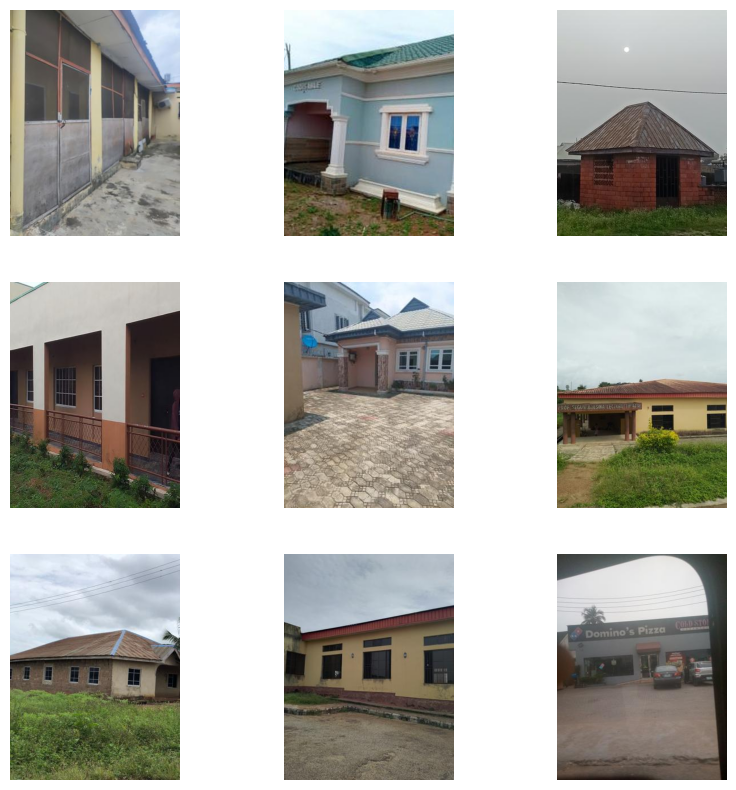

In [6]:
bungalow_building = list(images_dir.glob("Bungalow/*"))

plt.figure(figsize=((10,10)))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = PIL.Image.open(bungalow_building[i])
    plt.imshow(img)
    plt.axis("off")

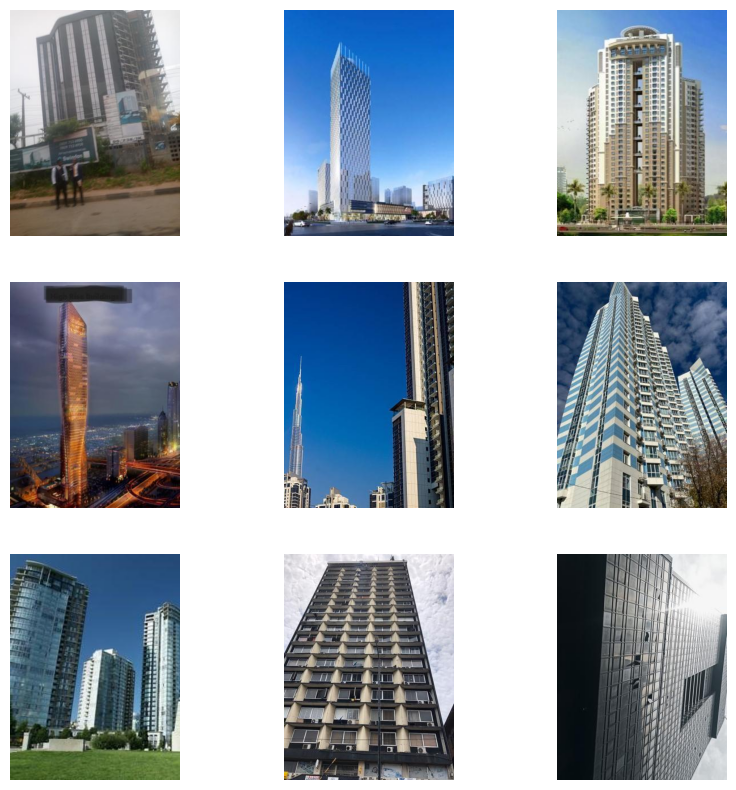

In [7]:
high_rise_building = list(images_dir.glob("High-rise/*"))

plt.figure(figsize=((10,10)))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = PIL.Image.open(high_rise_building[i])
    plt.imshow(img)
    plt.axis("off")

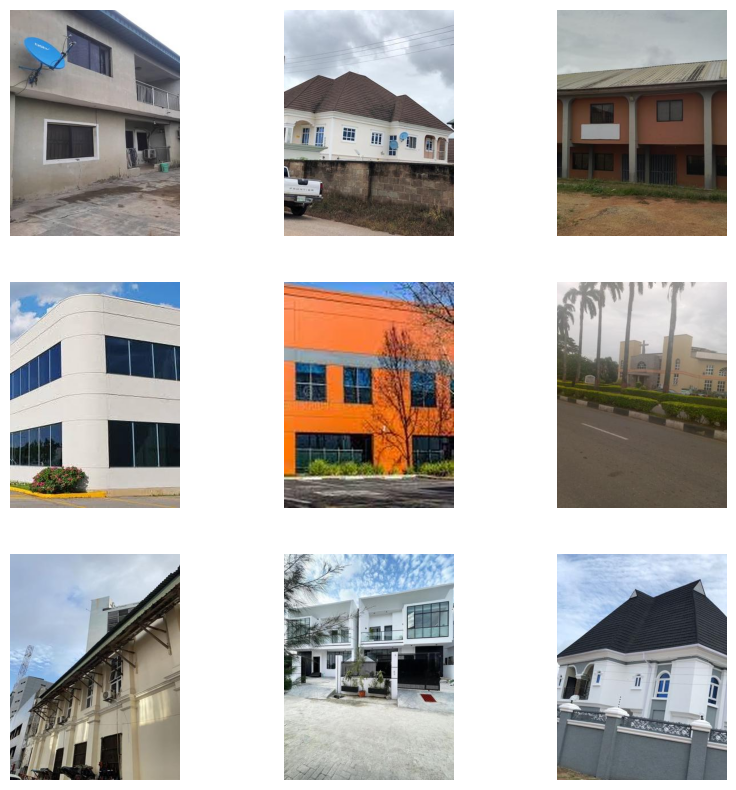

In [8]:
storey_building = list(images_dir.glob("Storey-building/*"))

plt.figure(figsize=((10,10)))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = PIL.Image.open(storey_building[i])
    plt.imshow(img)
    plt.axis("off")

# Split Dataset

In [9]:
# splitfolders.ratio(images_dir, output="Output", seed=1337, ratio=(0.8, 0.1, 0.1), group_prefix=None, move=False)

In [10]:
BATCH_SIZE = 32
IMG_HEIGHT = 256
IMG_WIDTH = 256

In [11]:
train_ds = image_dataset_from_directory(
    images_dir,
    validation_split = 0.2,
    subset='training',
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
    
)

Found 1191 files belonging to 3 classes.
Using 953 files for training.


In [12]:
val_ds = image_dataset_from_directory(
    images_dir,
    validation_split = 0.2,
    subset='validation',
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
    
)

Found 1191 files belonging to 3 classes.
Using 238 files for validation.


In [13]:
class_names = train_ds.class_names
class_names


['Bungalow', 'High-rise', 'Storey-building']

In [14]:
num_class = len(class_names)
num_class

3

2023-10-30 10:23:32.975709: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [953]
	 [[{{node Placeholder/_4}}]]
2023-10-30 10:23:32.976226: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [953]
	 [[{{node Placeholder/_4}}]]


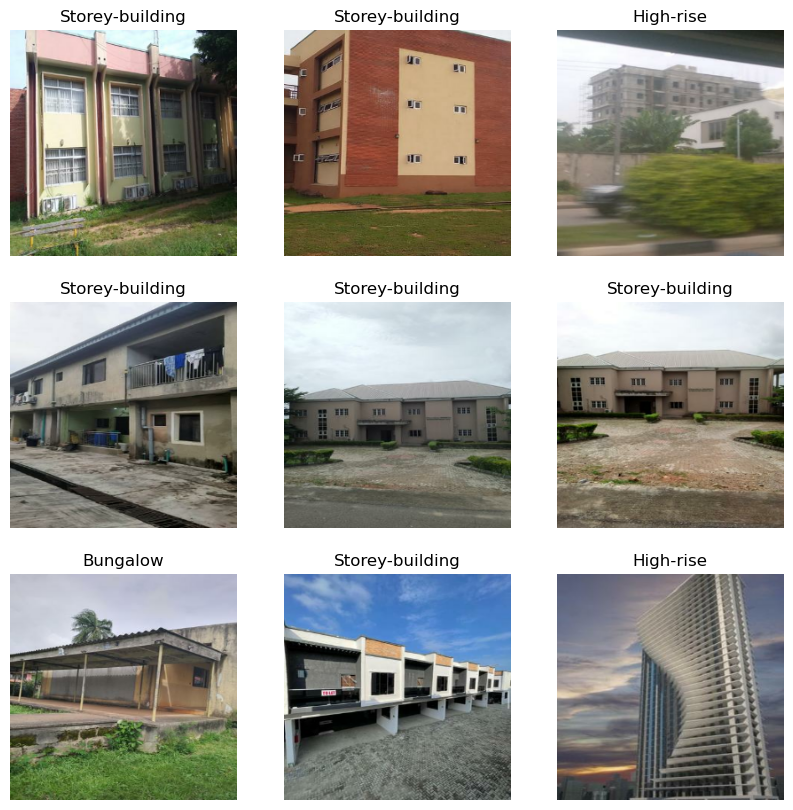

In [15]:
# Display random images from the dataset with their respective labels
for images, labels in train_ds.take(1):
    plt.figure(figsize=((10,10)))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Preprocessing

In [16]:
# setting up the base model

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [17]:
# augmentation layer
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2)
])

In [18]:
# preprocess input
preprocess_input = preprocess_input

In [19]:
base_model = ResNet50(
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    include_top=False,
    weights="imagenet"
)

In [20]:
base_model.trainable = False

In [21]:
global_avg_layer = GlobalAveragePooling2D()
prediction_layer = Dense(num_class)

# Building the Model

In [22]:
inputs = Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_avg_layer(x)
x = Dropout(0.2)(x)
outputs = prediction_layer(x)

In [23]:
model = Model(inputs=inputs, outputs=outputs)

In [24]:
optimizer = Adam(learning_rate=0.0001)

In [25]:
model.compile(
    optimizer=optimizer,
    loss = SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem (  (None, 256, 256, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 256, 256, 3)       0         
 )                                                               
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0     

# Training the Model

In [27]:
model.evaluate(val_ds)

2023-10-30 10:23:54.765640: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [238]
	 [[{{node Placeholder/_4}}]]
2023-10-30 10:23:54.765849: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [238]
	 [[{{node Placeholder/_0}}]]


8/8 [==============================] - 9s 888ms/step - loss: 1.3502 - accuracy: 0.3403


[1.3502408266067505, 0.3403361439704895]

In [28]:
epochs = 20

history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

Epoch 1/20


2023-10-30 10:24:08.842299: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [953]
	 [[{{node Placeholder/_4}}]]
2023-10-30 10:24:08.842648: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [953]
	 [[{{node Placeholder/_4}}]]


30/30 [==============================] - 44s 1s/step - loss: 1.2282 - accuracy: 0.3924 - val_loss: 0.9337 - val_accuracy: 0.5546
Epoch 2/20
30/30 [==============================] - 40s 1s/step - loss: 1.0153 - accuracy: 0.5110 - val_loss: 0.8363 - val_accuracy: 0.5630
Epoch 3/20
30/30 [==============================] - 42s 1s/step - loss: 0.8792 - accuracy: 0.5887 - val_loss: 0.7620 - val_accuracy: 0.5882
Epoch 4/20
30/30 [==============================] - 41s 1s/step - loss: 0.7806 - accuracy: 0.6390 - val_loss: 0.7153 - val_accuracy: 0.6092
Epoch 5/20
30/30 [==============================] - 37s 1s/step - loss: 0.7048 - accuracy: 0.6821 - val_loss: 0.6789 - val_accuracy: 0.6429
Epoch 6/20
30/30 [==============================] - 37s 1s/step - loss: 0.6500 - accuracy: 0.7083 - val_loss: 0.6633 - val_accuracy: 0.6555
Epoch 7/20
30/30 [==============================] - 37s 1s/step - loss: 0.6220 - accuracy: 0.7345 - val_loss: 0.6138 - val_accuracy: 0.7101
Epoch 8/20
30/30 [=============

In [29]:
results = history.history

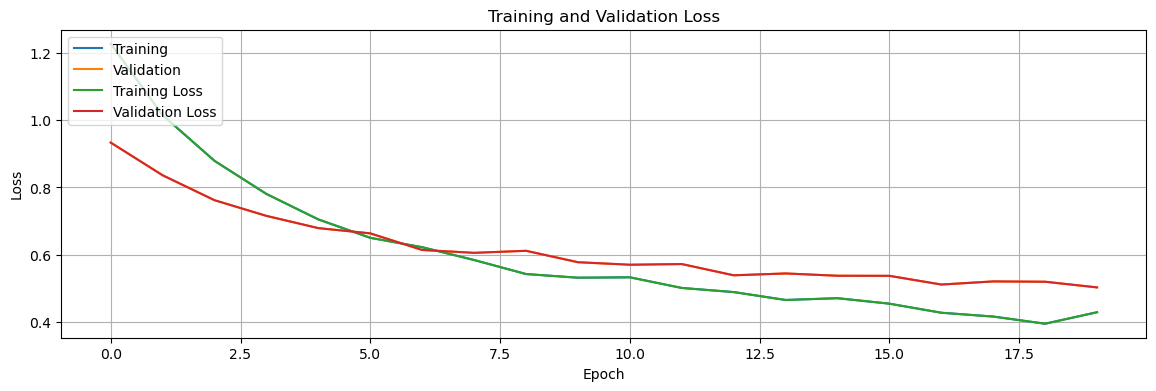

In [30]:
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs_range = range(epochs)

plt.figure(figsize=(14,4))
plt.grid(True)
plt.plot(epochs_range, results['loss'], label='Training')
plt.plot(epochs_range, results['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper left")
plt.title("Training and Validation Loss")

plt.show()

/var/folders/xw/pwz17bjx46g_9vlzq0yxkrwh0000gq/T/ipykernel_54165/1434515732.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


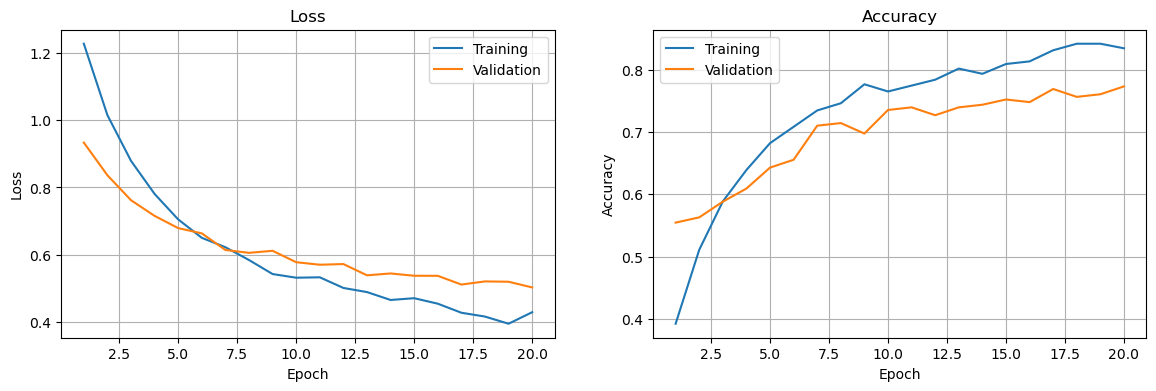

In [31]:
# plot results

n_epochs = len(results['loss'])

plt.figure(figsize=[14,4])
plt.grid(True)
plt.subplot(1,2,1)
plt.plot(range(1, n_epochs+1), results['loss'], label='Training')
plt.plot(range(1, n_epochs+1), results['val_loss'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss')
plt.legend()
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(range(1, n_epochs+1), results['accuracy'], label='Training')
plt.plot(range(1, n_epochs+1), results['val_accuracy'], label='Validation')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
predictions = model.evaluate(val_ds)

8/8 [==============================] - 7s 836ms/step - loss: 0.5023 - accuracy: 0.7731


# Saving model

In [ ]:
# Save the entire model as a ".keras" zip archive.
model.save('image_classification_model.keras')

In [ ]:
# Save model as "HDF5" format, to store architecture, weights, configuration
model.save("image_classification_model.h5")

In [ ]:
# Save the model as ".pkl"

import pickle
pickle.dump(model, open('image_classification_model.pkl', 'wb'))